In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gmaps
import sys
sys.path.insert(0, 'Data')
from config import gkey

accident_data = pd.read_csv("Data/accident_data.csv")

In [2]:
# Data cleanup

# Filters out dates containing 2016, 2017, & 2019 -- too much data in dataset to handle with laptops
df = accident_data[~accident_data["Start_Time"].str.contains("2016")]
df = df[~df["Start_Time"].str.contains("2017")]
df = df[~df["Start_Time"].str.contains("2019")]

# Splits the Start_Time column into individual columns
df[["Date", "Time"]] = df["Start_Time"].str.split(expand=True)

# Renames columns to be more readable
df = df.rename(columns={"Start_Lat":"Lat", "Start_Lng":"Lng", "Weather_Condition":"Weather"})

# Filters and rearranges dataset to display most useful columns
df = df[["Date", "Time", "Lat", "Lng", "City", "State",
         "County", "Weather", "Temperature(F)", "Severity"]]

# Iterates through all column data to find NaN values and adds them to a list
# df.columns[df.isna().any()].tolist()
# Output: ['City', 'Weather', 'Temperature(F)']

# df.head(10)

In [15]:
# Creates a smaller dataframe for weather-specific purposes

weather_df = df[["Date", "City", "Weather"]]

weather_df = weather_df.reset_index()

# weather_df.head()

In [4]:
# Renames most columns in weather data to lessen graph density

weather_df["Weather"] = weather_df["Weather"].replace({
    
    # Cloudy conditions
    "Mostly Cloudy":"Cloudy",
    "Scattered Clouds":"Cloudy",
    "Partly Cloudy":"Cloudy",
    
    # Rainy conditions
    "Light Rain":"Rain",
    "Heavy Rain":"Rain",
    "Light Drizzle":"Rain",
    "Light Thunderstorms and Rain":"Rain",
    "Heavy Thunderstorms and Rain":"Rain",
    "Heavy Rain Showers":"Rain",
    "Drizzle":"Rain",
    "Storm":"Rain",
    "Light Freezing Rain":"Rain",
    "Heavy Drizzle":"Rain",
    "Thunderstorms and Rain":"Rain",
    "Light Freezing Drizzle":"Rain",
    "Light Rain Showers":"Rain",
    "Light Thunderstorm":"Rain",
    "Heavy Freezing Rain":"Rain",
    "Heavy Freezing Drizzle":"Rain",
    "Squalls":"Rain",
    "Rain Showers":"Rain",
    "Thunderstorm":"Rain",
    
    # Foggy conditions
    "Patches of Fog":"Fog",
    "Shallow Fog":"Fog",
    "Mist":"Fog",
    "Light Freezing Fog":"Fog",
    "Haze":"Fog",
    "Light Haze":"Fog",
    
    # Snow conditions
    "Light Snow":"Snow",
    "Blowing Snow":"Snow",
    "Light Snow Showers":"Snow",
    "Heavy Snow":"Snow",
    "Light Snow Grains":"Snow",
    "Light Thunderstorms and Snow":"Snow",
    "Heavy Blowing Snow":"Snow",
    "Light Blowing Snow":"Snow",
    "Thunderstorms and Snow":"Snow",
    "Snow Showers":"Snow",
    
    # Other conditions
    "Hail":"Misc/Other",
    "Light Ice Pellets":"Misc/Other",
    "Small Hail":"Misc/Other",
    "Light Hail":"Misc/Other",
    "Heavy Thunderstorms with Small Hail":"Misc/Other",
    "Ice Pellets":"Misc/Other",
    "Smoke":"Misc/Other",
    "Heavy Smoke":"Misc/Other",
    "Volcanic Ash":"Misc/Other",
    "Widespread Dust":"Misc/Other",
    "Sand":"Misc/Other",
    "Funnel Cloud":"Misc/Other"
})

# weather_df["Weather"].value_counts()

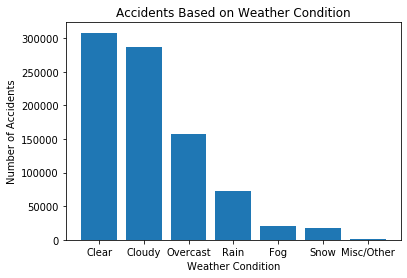

In [5]:
# Bar graph for number of accidents vs. weather conditions
# across reported 201 accidents

x_axis = np.arange(len(weather_df["Weather"].value_counts()))
weather_counts = weather_df["Weather"].value_counts()

plt.bar(x_axis, weather_counts)

plt.title("Accidents Based on Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Number of Accidents")

tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, ["Clear", "Cloudy", "Overcast", "Rain", "Fog", "Snow", "Misc/Other"])

plt.show()

In [6]:
# Generates a list of cities that have an accident count greater than 500 (263 total cities)
city_counts = weather_df["City"].value_counts()
cities = city_counts[city_counts > 500 ].index.tolist()

rain_accident = 0
total_rain_accident = 0
clear_accident = 0
total_clear_accident = 0

city_weather_df = pd.DataFrame({
    "City":[],
    "Clear Days":[],
    "Clear Accidents":[],
    "Accidents/Clear Day":[],
    "Rain Days":[],
    "Rain Accidents":[],
    "Accidents/Rain Day":[],
    "Difference":[]
})

for city in cities:     
        
    # Iterates through city list and separates rainy days and clear days
    city_df = weather_df.loc[(weather_df["City"] == city), :]
    rainy_days = city_df.loc[(city_df["Weather"] == "Rain")]
    sunny_days = city_df.loc[(city_df["Weather"] == "Clear")]
    
    # Unique & total dates involving clear skies
    clear_days = len(sunny_days["Date"].unique())
    clear_accidents = len(sunny_days)
    
    # Unique & total dates involving rain
    rain_days = len(rainy_days["Date"].unique())
    rain_accidents = len(rainy_days)
    
    # Average accidents for given weather
    try:
        clear_avg_accidents = round((clear_accidents/clear_days), 2)
        rain_avg_accidents = round((rain_accidents/rain_days), 2)
    except:
        continue
        
    difference = clear_avg_accidents - rain_avg_accidents

    
    # Appends to a dataframe
    city_weather_df = city_weather_df.append({
        "City":city,
        "Clear Days":clear_days,
        "Clear Accidents":clear_accidents,
        "Accidents/Clear Day":clear_avg_accidents,
        "Rain Days":rain_days,
        "Rain Accidents":rain_accidents,
        "Accidents/Rain Day":rain_avg_accidents,
        "Difference":difference
    },
    ignore_index=True
    )

In [7]:
# Sorts previously created dataframe to determine worst cities to drive in
sorted_city_weather_df = city_weather_df.sort_values(by=["Difference"], ascending=False)

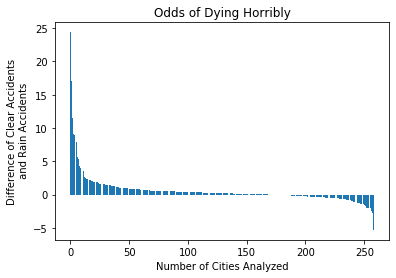

In [8]:
# Bar graph to show the difference between clear skies accidents
# and rainy day accidents. Positive numbers mean more clear skies;
# negative means more rainy days.
x_axis = np.arange(len(city_weather_df))

plt.bar(x_axis, sorted_city_weather_df["Difference"])

plt.title("Odds of Dying Horribly")
plt.xlabel("Number of Cities Analyzed")
plt.ylabel("Difference of Clear Accidents\n and Rain Accidents")

plt.show()

In [9]:
# Used & commented to find the worst cities to drive in for rain, clear skies, or ever:
# sorted_city_weather_df.loc[sorted_city_weather_df["Difference"] == 0]
    # Value: North Charleston (even odds of accident)
    
# sorted_city_weather_df.iloc[-1]
    # Value: Rochester (worst city to drive in rain)
    
# sorted_city_weather_df.iloc[0]
    # Value: Houston (worst city to drive in clear skies)
    
# sorted_city_weather_df.loc[sorted_city_weather_df["City"] == "Raleigh"]
    # Value: Raleigh (1.3 more accidents in the rain per day)